## Agente Planejador-Executor

In [1]:
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-1.5-flash")

llm.invoke("Olá, Mundo!").content

'Olá, Mundo! 👋 😄\n\nQue bom te ver por aqui! ✨  O que você gostaria de fazer hoje? 😊 \n'

In [ ]:
# Definindo o estado

import operator
from typing_extensions import TypedDict
from typing import Annotated, List, Tuple

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [4]:
# Estrutura de resposta do LLM para a etapa de planejamento

from pydantic import BaseModel, Field

class Plan(BaseModel):
    """Plano a seguir no futuro"""

    steps: List[str] = Field(
        description="diferentes etapas a seguir, devem estar em ordem de classificação"
    )

In [6]:
# Codando o planner agent

from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Para o objetivo dado, crie um plano simples passo a passo. \
            Este plano deve envolver tarefas individuais que, se executadas corretamente, produzirão a resposta correta. Não adicione nenhuma etapa supérflua. \
            O resultado da etapa final deve ser a resposta final. Certifique-se de que cada etapa tenha todas as informações necessárias - não pule etapas.""",
        ),
        (
            "placeholder",
            "{messages}"
        )
    ]
)

planner = planner_prompt | llm.with_structured_output(Plan)

In [11]:
# Testando o planner

planner.invoke(
    {
        "messages": [
            (
                "user",
                "Em que ano foi construído as 3 maiores capitais do Brasil?"
            )
        ]
    }
)

Plan(steps=['Encontrar as 3 maiores capitais do Brasil em termos de população.', 'Encontrar o ano em que cada uma dessas capitais foi fundada.', 'Combinar o nome da capital com o ano de fundação.'])

In [13]:
from typing import Union

class Response(BaseModel):
    """Responder ao usuário"""
    
    response: str

class Act(BaseModel):
    """Ação a ser executada"""

    action: Union[Response, Plan] = Field(
        description="Ação a ser executada. Se você quiser responder ao usuário, use Response. Se você precisar usar mais ferramentas para obter a resposta, use Plan."
    )

prompt_replanner = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Para o objetivo dado, crie um plano simples passo a passo. \
            Este plano deve envolver tarefas individuais que, se executadas corretamente, produzirão a resposta correta. Não adicione etapas supérfluas. \
            O resultado da etapa final deve ser a resposta final. Certifique-se de que cada etapa tenha todas as informações necessárias - não pule etapas.

            Seu objetivo era este:
            {input}

            Seu plano original era este:
            {plan}

            Você atualmente fez as seguintes etapas:
            {past_steps}

            Atualize seu plano adequadamente. Se não forem necessárias mais etapas e você puder retornar ao usuário, responda com isso. Caso contrário, preencha o plano. Adicione apenas etapas ao plano que ainda PRECISAM ser feitas. Não retorne etapas feitas anteriormente como parte do plano."""
        )
    ]
)

replanner = prompt_replanner | llm.with_structured_output(Act)


Key '$defs' is not supported in schema, ignoring


In [26]:
from typing import Literal
from langgraph.graph import END

async def execute_steps(state: PlanExecute):
    plan = state['plan']
    plan_str = "\n".join(f"{i+1}.{step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""Dentro do planejamento: {plan_str}\n
    Você deve executar a tarefa {1}: {task}"""

    agent_response = await llm.ainvoke(task_formatted)

    return {
        "past_steps": [(task, agent_response["messages"][-1].content)]
    }

async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {
        "plan": plan.steps
    }

async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}
    
async def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [43]:
from langgraph.graph import StateGraph, START

# Inciando o grafo
graph_builder = StateGraph(PlanExecute)

# Adicionando os nós
graph_builder.add_node("planner", plan_step)
graph_builder.add_node("agent", execute_steps)
graph_builder.add_node("replanner", replan_step)

# Configurando as pontes (edges)
graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "agent")
graph_builder.add_edge("agent", "replanner")
graph_builder.add_conditional_edges("replanner", should_end, ["agent", END])

# Compilando o grafo e preparando para execução
app = graph_builder.compile()

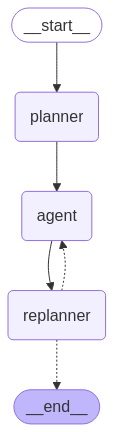

In [29]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [58]:
result = await app.ainvoke({
    "input": "Who won the 2024 Australian Open men's title?",
})

InvalidUpdateError: Must write to at least one of ['query', 'plan', 'past_steps', 'response']